# Project : 다양한 OCR모델 비교하기

## Step1. 검증용 데이터셋 준비

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join
import numpy
import cv2
import os

In [23]:
# load images
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
test_files = tf.io.gfile.glob(str(ROOT_PATH + '/ocr_python/test/*jpg'))
# test_kor_files = tf.io.gfile.glob(str(ROOT_PATH + '/ocr_python/test/kor/*'))
test_files

['/aiffel/aiffel/ocr_python/test/eng.jpg',
 '/aiffel/aiffel/ocr_python/test/study.jpg',
 '/aiffel/aiffel/ocr_python/test/kor.jpg',
 '/aiffel/aiffel/ocr_python/test/poster.jpg',
 '/aiffel/aiffel/ocr_python/test/sudoku.jpg',
 '/aiffel/aiffel/ocr_python/test/layers.jpg']

In [24]:
image_titles = []
images = []
for filename in test_files:
        img=cv2.imread(filename)
        img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)                         
        images.append(img)
        image_titles.append(os.path.splitext(os.path.basename(filename))[0])
print(image_titles)

['eng', 'study', 'kor', 'poster', 'sudoku', 'layers']


In [17]:
image_kor_titles = []
images_kor = []
for filename in test_kor_files:
        img=cv2.imread(filename)
        img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)                         
        images.append(img)
        image_kor_titles.append(os.path.splitext(os.path.basename(filename))[0])
print(image_kor_titles)

['kor']


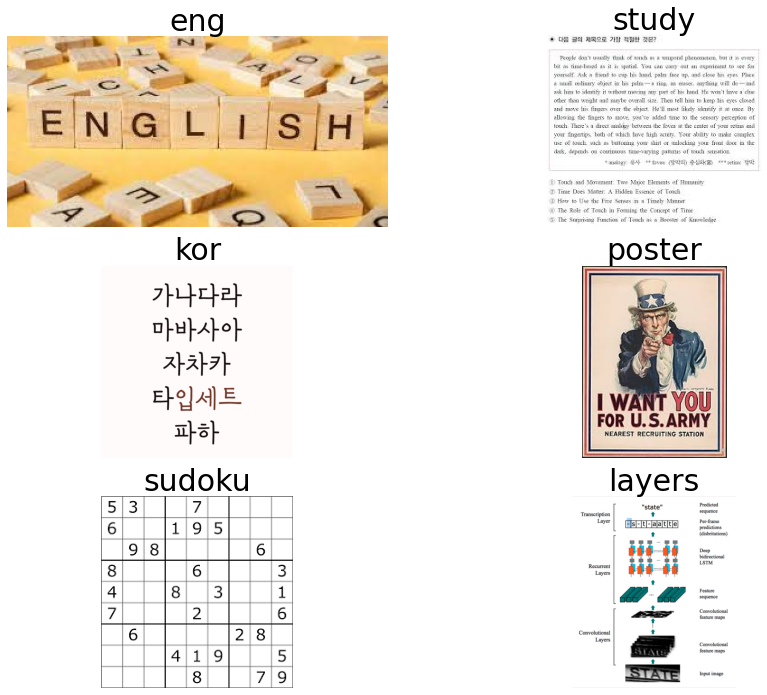

In [25]:
plt.figure(figsize=(15,12))

for i in range(len(images)):
    plt.subplot(3, 2, i+1) 
    plt.imshow(images[i])
    plt.title(image_titles[i], fontsize=30)
    plt.axis('off')
    
plt.show()

## Step2. Google OCR API, keras-ocr, Tesseract로 테스트 진행

In [26]:
def detect_text(path):
    """Detects text in the file."""
    from google.cloud import vision
    import io
    client = vision.ImageAnnotatorClient()

    with io.open(path, 'rb') as image_file:
        content = image_file.read()
        
    image = vision.Image(content=content)

    response = client.text_detection(image=image)
    texts = response.text_annotations
    print('Texts:')

    for text in texts:
       print('\n"{}"'.format(text.description))

    vertices = (['({},{})'.format(vertex.x, vertex.y)
                 for vertex in text.bounding_poly.vertices])

    print('bounds: {}'.format(','.join(vertices)))

    if response.error.message:
        raise Exception(
            '{}\nFor more info on error messages, check: '
            'https://cloud.google.com/apis/design/errors'.format(
                response.error.message))

In [27]:
# 다운받은 인증키 경로가 정확하게 지정되어 있어야 합니다. 
!ls -l $GOOGLE_APPLICATION_CREDENTIALS

import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] =  os.getenv('HOME')+'/aiffel/ocr_python/my_google_api_key.json'

# 위에서 정의한 OCR API 이용 함수를 호출해 봅시다.
for file in zip(test_files):
    detect_text(file)
    print("----------------------------------------------")

total 416
drwxr-xr-x 35 root root   4096 Sep 21 00:08 aiffel
-rw-r--r--  1 root root 418843 Sep 21 00:31 Exploration_lc18_project.ipynb


DefaultCredentialsError: File /aiffel/aiffel/ocr_python/my_google_api_key.json was not found.

In [ ]:
import matplotlib.pyplot as plt
import keras_ocr

# keras-ocr이 detector과 recognizer를 위한 모델을 자동으로 다운로드받게 됩니다. 
pipeline = keras_ocr.pipeline.Pipeline()

In [ ]:
prediction_groups = [pipeline.recognize([file]) for file in test_files]

In [ ]:
# Plot the predictions
fig, axs = plt.subplots(nrows=len(images), figsize=(80, 80))
for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=images[idx], 
                                    predictions=prediction_groups[idx][0], ax=ax)

In [ ]:
import os
import pytesseract
from PIL import Image
from pytesseract import Output
import matplotlib.pyplot as plt

# OCR Engine modes(–oem):
# 0 - Legacy engine only.
# 1 - Neural nets LSTM engine only.
# 2 - Legacy + LSTM engines.
# 3 - Default, based on what is available.

# Page segmentation modes(–psm):
# 0 - Orientation and script detection (OSD) only.
# 1 - Automatic page segmentation with OSD.
# 2 - Automatic page segmentation, but no OSD, or OCR.
# 3 - Fully automatic page segmentation, but no OSD. (Default)
# 4 - Assume a single column of text of variable sizes.
# 5 - Assume a single uniform block of vertically aligned text.
# 6 - Assume a single uniform block of text.
# 7 - Treat the image as a single text line.
# 8 - Treat the image as a single word.
# 9 - Treat the image as a single word in a circle.
# 10 - Treat the image as a single character.
# 11 - Sparse text. Find as much text as possible in no particular order.
# 12 - Sparse text with OSD.
# 13 - Raw line. Treat the image as a single text line, bypassing hacks that are Tesseract-specific.

def crop_word_regions(image_path='./images/sample.png', output_path='./output'):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3'
    image = Image.open(image_path)

    recognized_data = pytesseract.image_to_data(
        image, lang='eng',    # 한국어라면 lang='kor'
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    top_level = max(recognized_data['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
    
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            
            output_img_path = os.path.join(output_path, f"{str(index).zfill(4)}.png")
            print(output_img_path)
            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1
    return cropped_image_path_list

In [ ]:
def recognize_images(cropped_image_path_list):
    custom_oem_psm_config = r'--oem 3 --psm 7'
    
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang='eng',    # 한국어라면 lang='kor'
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        print(recognized_data['text'])
    print("Done")

In [ ]:
# 위에서 준비한 문자 영역 파일들을 인식하여 얻어진 텍스트를 출력합니다.
for file, title in zip(test_files, image_titles):
    image_path = os.path.join('./tesseract', title)
    os.makedirs(image_path, exist_ok=True)
    cropped_image_path_list = crop_word_regions(file, image_path)
    recognize_images(cropped_image_path_list)

In [ ]:
def crop_word_regions_kor(image_path='./images/sample.png', output_path='./output'):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3'
    image = Image.open(image_path)

    recognized_data = pytesseract.image_to_data(
        image, lang='kor',    # 한국어라면 lang='kor'
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    top_level = max(recognized_data['level'])
    index = 0
    cropped_image_path_list_kor = []
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
    
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            
            output_img_path = os.path.join(output_path, f"{str(index).zfill(4)}.png")
            print(output_img_path)
            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list_kor.append(output_img_path)
            index += 1
    return cropped_image_path_list_kor

In [ ]:
def recognize_images_kor(cropped_image_path_list):
    custom_oem_psm_config = r'--oem 3 --psm 7'
    
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang='kor',    # 한국어라면 lang='kor'
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        print(recognized_data['text'])
    print("Done")

In [ ]:
# 위에서 준비한 문자 영역 파일들을 인식하여 얻어진 텍스트를 출력합니다.

for file, title in zip(test_kor_files, image_kor_titles):
    image_path = os.path.join('./tesseract', title)
    os.makedirs(image_path, exist_ok=True)
    cropped_image_path_list_kor = crop_word_regions_kor(file, image_path)
    recognize_images_kor(cropped_image_path_list_kor)

## Step3. 테스트 결과 정리

In [ ]:
import matplotlib.image as img

ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
path = os.getenv('HOME')+'/aiffel/ocr_python/test/'  
img_file_path = path + 'study.jpg'
detect_text(img_file_path)

plt.figure(figsize=(10,10))
img = img.imread(path + '2.png')
plt.imshow(img)
plt.show()

cropped_image_path_list = crop_word_regions(img_file_path, path)
recognize_images(cropped_image_path_list)

In [ ]:
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
path = os.getenv('HOME')+'/aiffel/ocr_python/test/'  
img_file_path = path + 'layers.jpg'
detect_text(img_file_path)

plt.figure(figsize=(10,10))
img = img.imread(path + '5.png')
plt.imshow(img)
plt.show()

cropped_image_path_list = crop_word_regions(img_file_path, path)
recognize_images(cropped_image_path_list)

In [ ]:
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
path = os.getenv('HOME')+'/aiffel/ocr_python/test/'  
img_file_path = path + 'eng.jpg'
detect_text(img_file_path)

plt.figure(figsize=(10,10))
img = img.imread(path + '6.png')
plt.imshow(img)
plt.show()

cropped_image_path_list = crop_word_regions(img_file_path, path)
recognize_images(cropped_image_path_list)

In [ ]:
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
path = os.getenv('HOME')+'/aiffel/ocr_python/test/'  
img_file_path = path + 'kor.jpg'
detect_text(img_file_path)

plt.figure(figsize=(10,10))
img = img.imread(path + '7.png')
plt.imshow(img)
plt.show()

cropped_image_path_list_kor = crop_word_regions_kor(img_file_path, path)
recognize_images_kor(cropped_image_path_list_kor)

## Step4. 결과 분석과 결론 제시

### 회고

- google api를 사용하지 못해서 진행하지 못했다.
